In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## Gradient Boosting in Scikit-Learn

Goals:
* Train Gradient Boosting Forest Classifier
* Plot decision boundary
* Observe the hyperparameters influence

(50, 2) (50,)


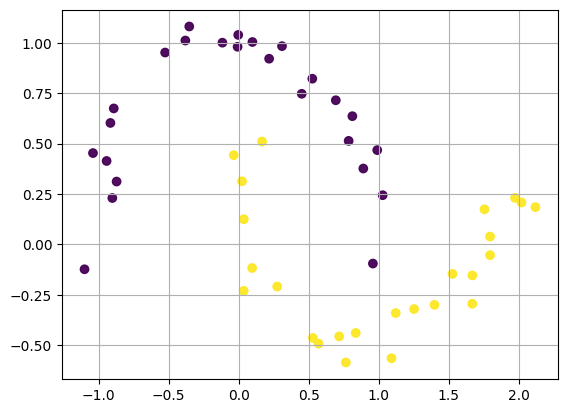

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=.1, n_samples=50)
X_test, y_test = make_moons(noise=.75)
print(X.shape, y.shape)

plt.scatter(X[:,0], X[:,1], c=y, alpha=0.95);
plt.grid(True);

## Plot decision boundary

In [3]:
def plot_boundary(y_pred, ax, i='log_prob'):
    y_pred = y_pred.reshape(x1.shape)
    ax.contourf(x1, x2, np.log(y_pred), cmap=plt.cm.RdYlBu, alpha=0.8)
    ax.scatter(X[:,0], X[:,1], c=y);
    ax.set_title(i)

Consider a `GradientBoostingClassifier` from sklearn with the default parameters. Fit the model and plot the decision boundary. 

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

# init the model
model = GradientBoostingClassifier(n_estimators=5)

#fit and calculate score
model.fit(X, y)
model.score(X_test, y_test)

0.69

In [5]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

x1, x2 = get_grid(X)
y_pred = model.predict_proba(np.c_[x1.ravel(), x2.ravel()])[:,0]

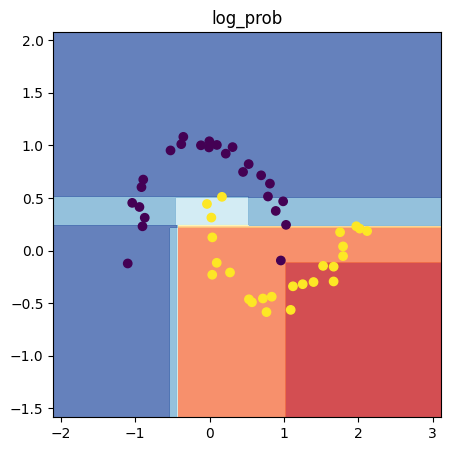

In [6]:
fig, ax = plt.subplots(1, figsize=(5,5))
plot_boundary(y_pred, ax)

Next, let us plot how the decision boundary changes when we increase the number of trees (base estimators).

In [7]:
# export sigmoid function
from scipy.special import expit

def iterative_predictions(X, model, n_estimators):
    # get probabilty of the class 1 for each tree separately (up to tree number `n_estimators`)
    raw = [tree[0].predict(X) for tree in model.estimators_[:n_estimators]]
    scores = np.zeros(X.shape[0])
    # combine predictions (weighted by the learning rate)
    for i in raw: 
        scores += i * model.learning_rate
    # use sigmoid to get proper final probability
    scores = expit(scores)
    return 1-scores

In [8]:
# test function `iterative_predictions`
n_estimators = model.n_estimators_
np.alltrue(iterative_predictions(X, model, n_estimators) == model.predict_proba(X)[:,0])

True

Using function `iterative_predictions`, we can plot boundary for different number of trees (from 1 to `max_estimators`)

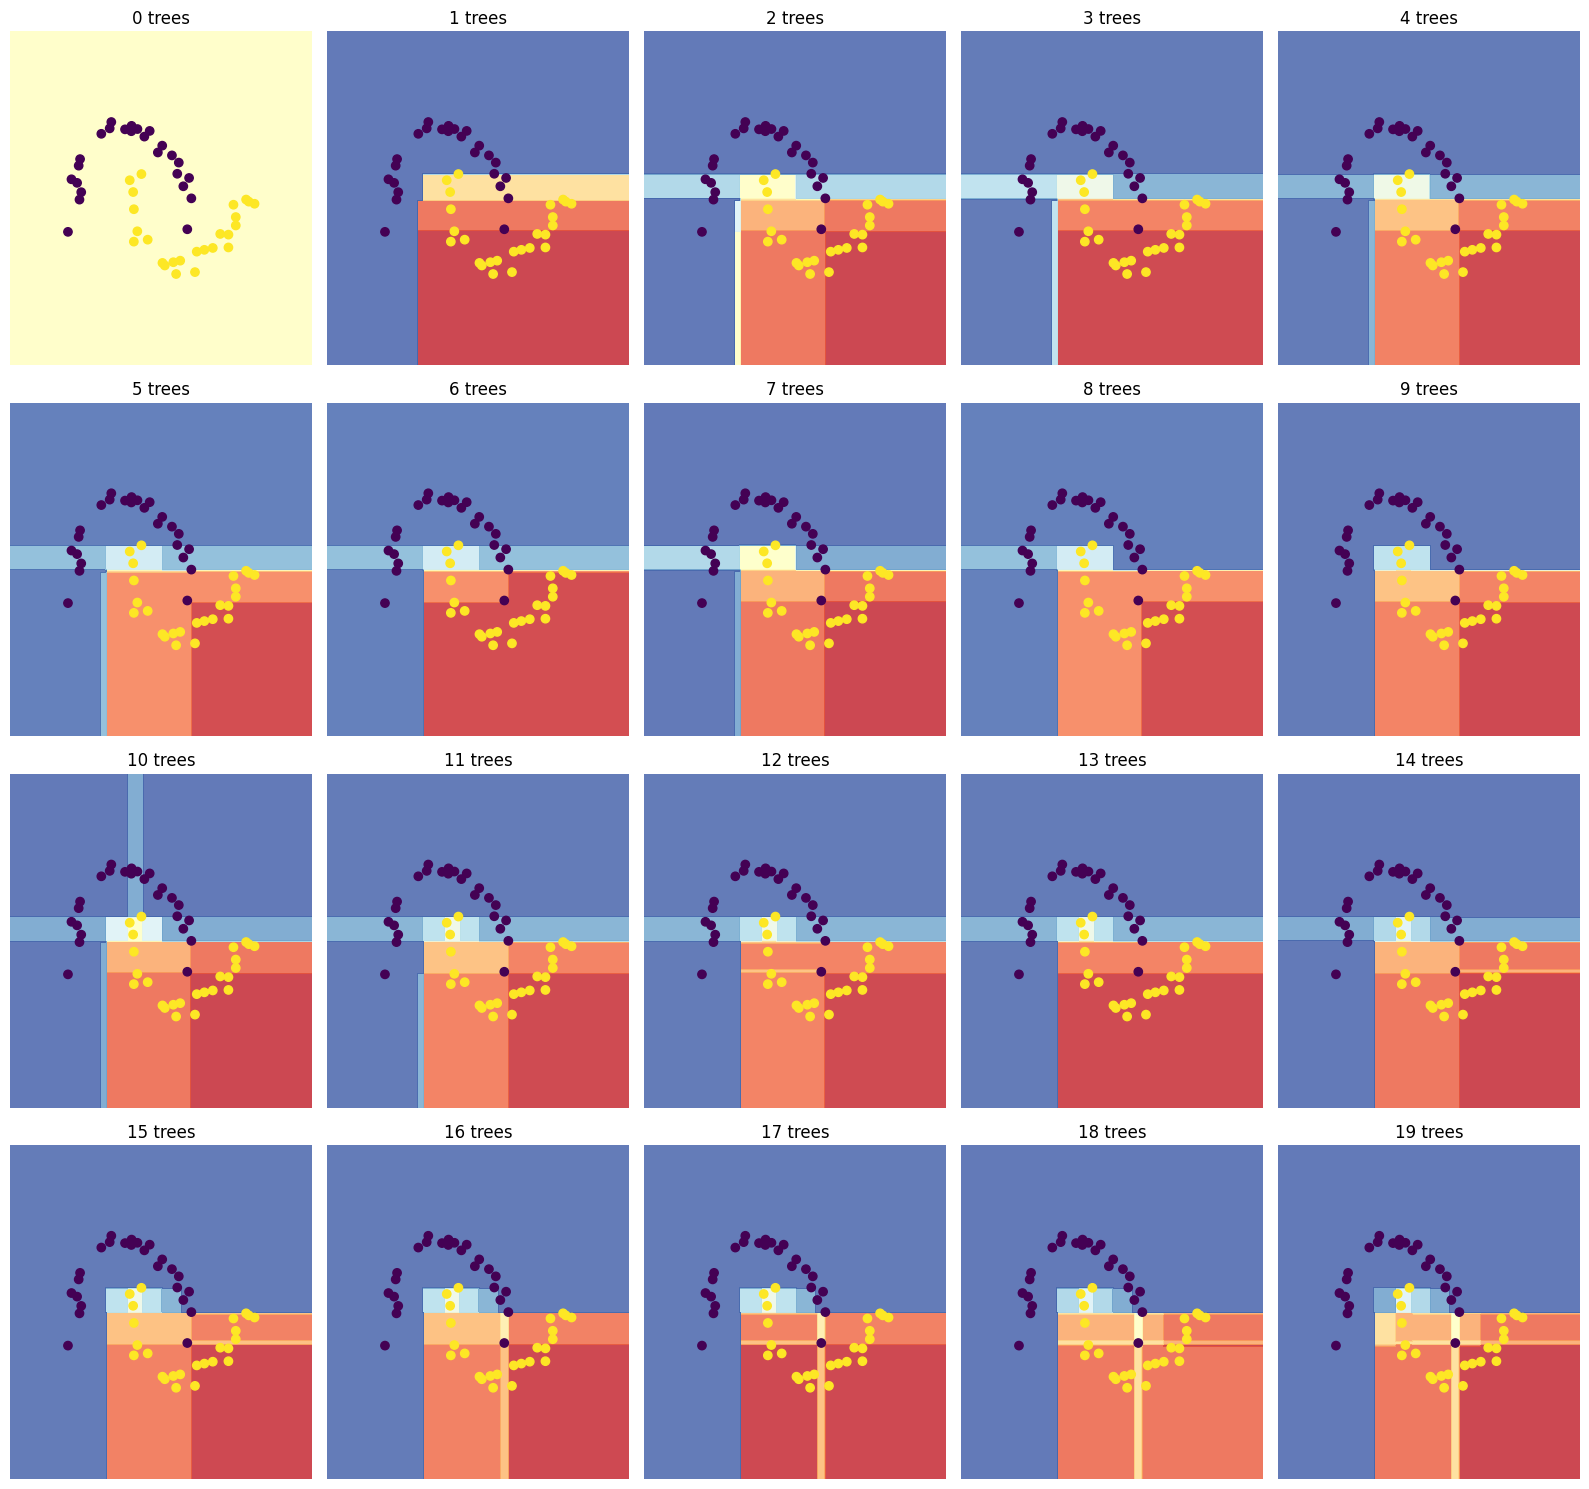

In [9]:
max_estimators = 20

model = GradientBoostingClassifier(n_estimators=max_estimators)
model.fit(X, y)
XX = np.c_[x1.ravel(), x2.ravel()]

fig, ax = plt.subplots(4, 5, figsize=(16,15))
for i in range(max_estimators):
    probs = iterative_predictions(XX, model, i)
    plot_boundary(probs, ax.flatten()[i], str(i) + ' trees')
    ax.flatten()[i].axis('off')
plt.tight_layout()

## Max_depth

Now let's also add a new "dimention". We will see how the boundary changes when when we change hyperparameter `max_depth` - maximal depth of the base model (decision tree).

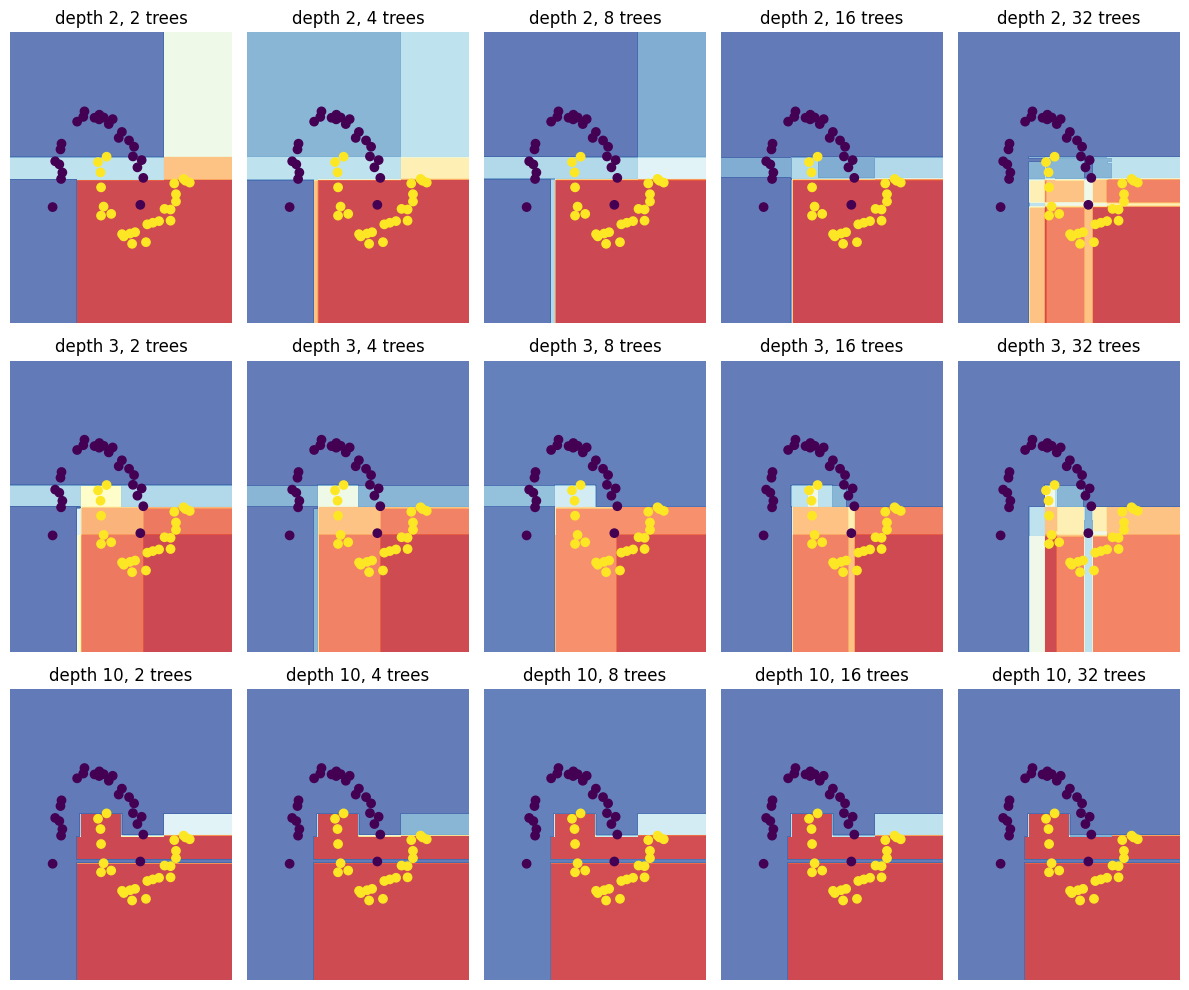

In [10]:
n_estimators_ls = [2, 4, 8, 16, 32] 
max_estimators = max(n_estimators_ls)
max_depth = [2, 3, 10]
XX = np.c_[x1.ravel(), x2.ravel()]

fig, ax = plt.subplots(len(max_depth), 5, figsize=(len(max_depth)*4,10))
                       
for dd, d in enumerate(max_depth):
    # train GB mode with the given depth
    model = GradientBoostingClassifier(n_estimators=max_estimators, max_depth=d)
    model.fit(X, y)
    
    # plot how decision boundaries change
    for ii, i in enumerate(n_estimators_ls):
        probs = iterative_predictions(XX, model, i)
        plot_boundary(probs, ax[dd].flatten()[ii],'depth '+ str(d)+', '+str(i)+' trees')
        ax[dd].flatten()[ii].axis('off')
plt.tight_layout()

To make things easier, let us write the function, which will draw the same plot as above for different hyperparameters.

In [11]:
def draw_hyper(dict_p, short_name=None):
    """
    dict_p - dictionary with the hyperparameter values
             e.g. {'values': [8, 32, 64], 'name': 'min_samples_split'}
    short_name - short name of the hyperparameter for the plot title

    """
    n_estimators_ls = [2, 4, 8, 16, 32]
    max_estimators = max(n_estimators_ls)
    XX = np.c_[x1.ravel(), x2.ravel()]
    if short_name is None:
        short_name = dict_p['name']
    
    fig, ax = plt.subplots(len(dict_p['values']), 5, figsize=(len(dict_p['values'])*4,10))     
    for j, val in enumerate(dict_p['values']):
        dict_in = {'n_estimators':max_estimators}
        dict_in[dict_p['name']] = val
        
        model = GradientBoostingClassifier(**dict_in)
        model.fit(X, y)
        for i, num_trees in enumerate(n_estimators_ls):
            probs = iterative_predictions(XX, model, num_trees)
            plot_boundary(probs, ax[j].flatten()[i], short_name + ' '+ str(val)+'; '+str(num_trees)+' trees')
            ax[j].flatten()[i].axis('off')
    plt.tight_layout()

# Min_samples_split

The first hyperparameter will be `min_samples_split` - minimal amout of samples required to make a split.

We observe, that if it is too large, the model is not learning (last row).

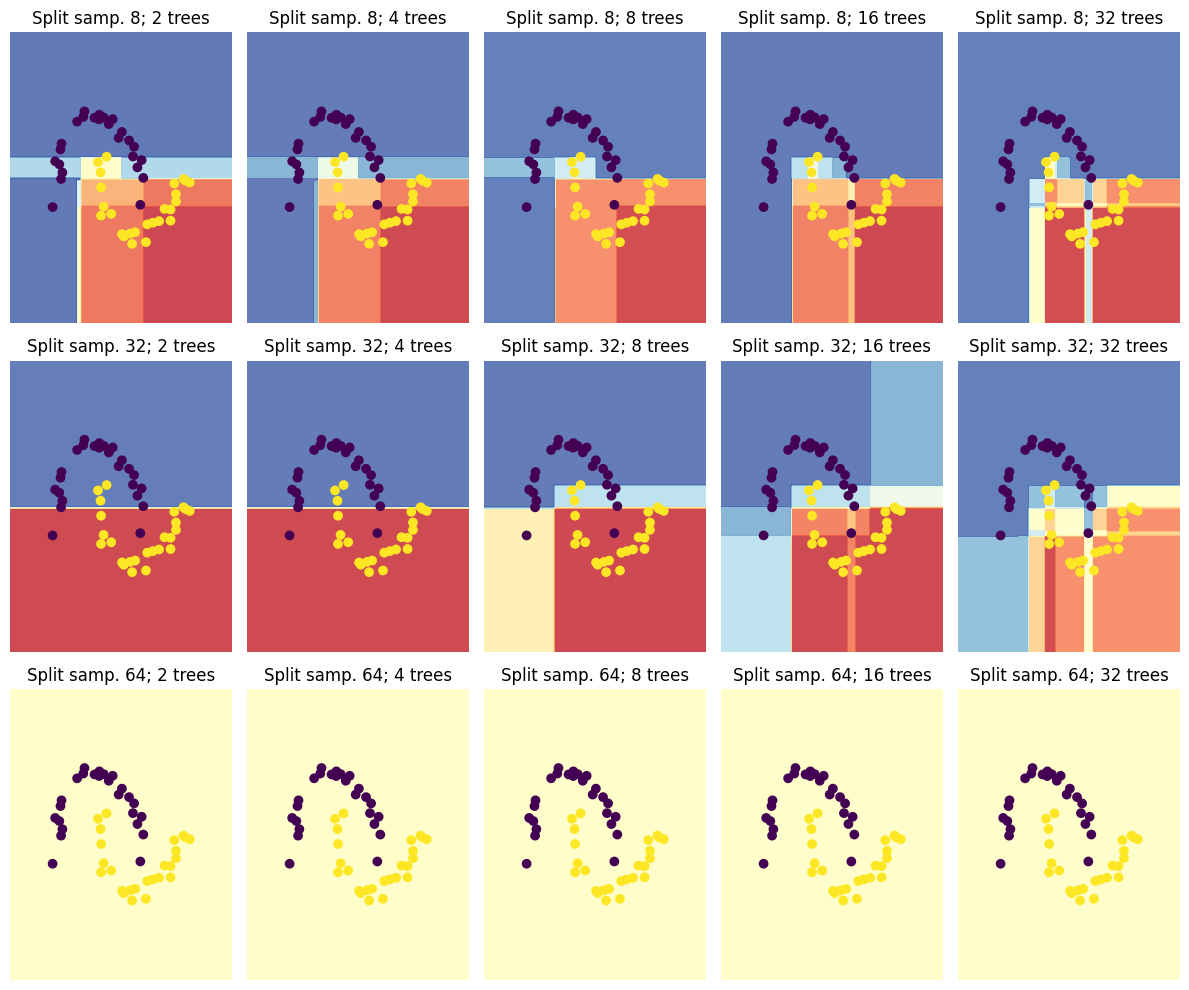

In [12]:
dict_p = {'values': [8, 32, 64], 'name': 'min_samples_split'}
draw_hyper(dict_p, short_name='Split samp.')

# Min_samples_leaf

Now, consider `min_samples_leaf`. 

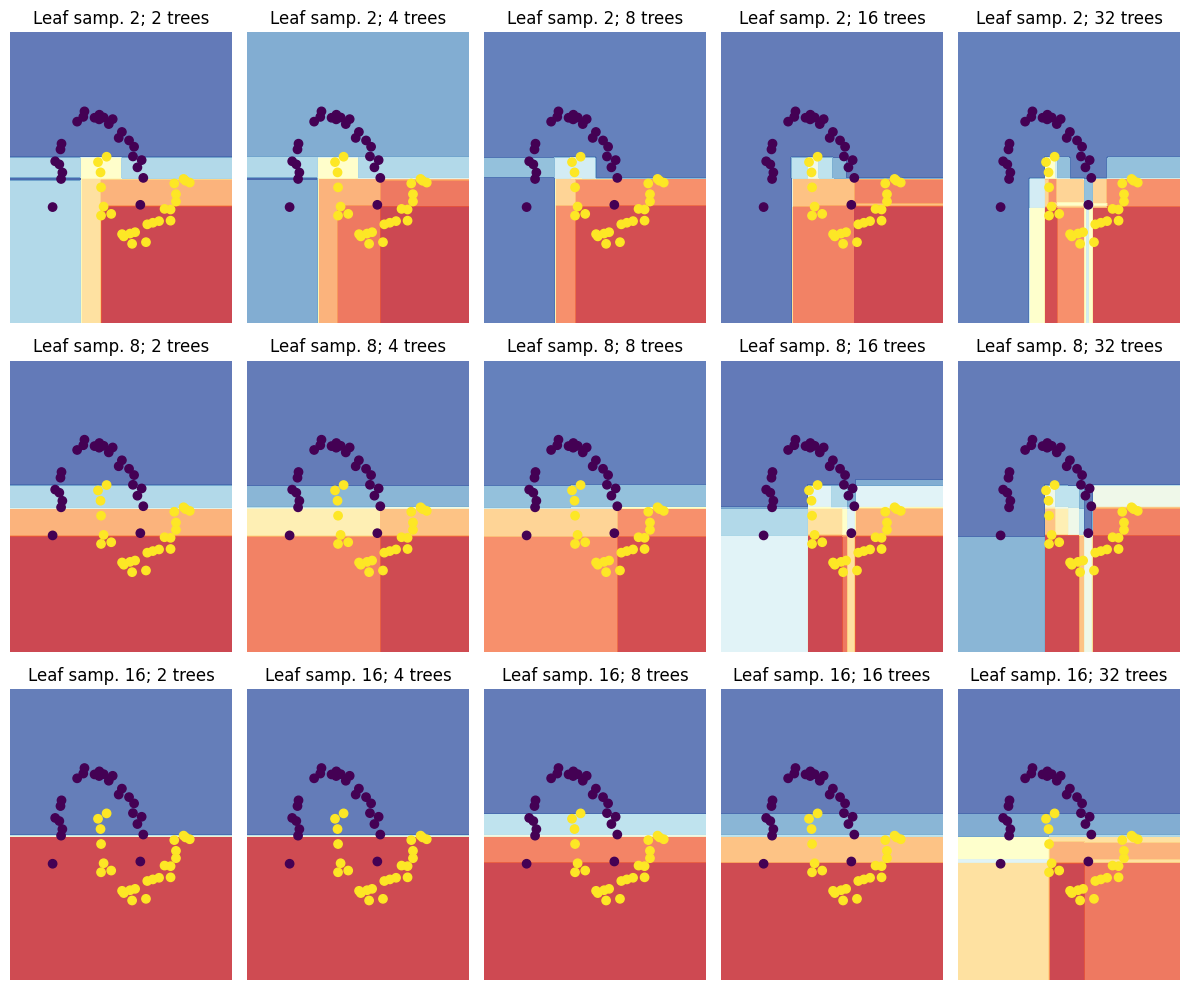

In [13]:
dict_p = {'values': [2, 8, 16], 'name': 'min_samples_leaf'}
draw_hyper(dict_p, short_name='Leaf samp.')

# Learning_rate

Learning rate controls the "speed". We observe, that for the small learning rate (first row), the model is training extremely slow. When the learning rate is too large (last row), the models ovefits quickly. 

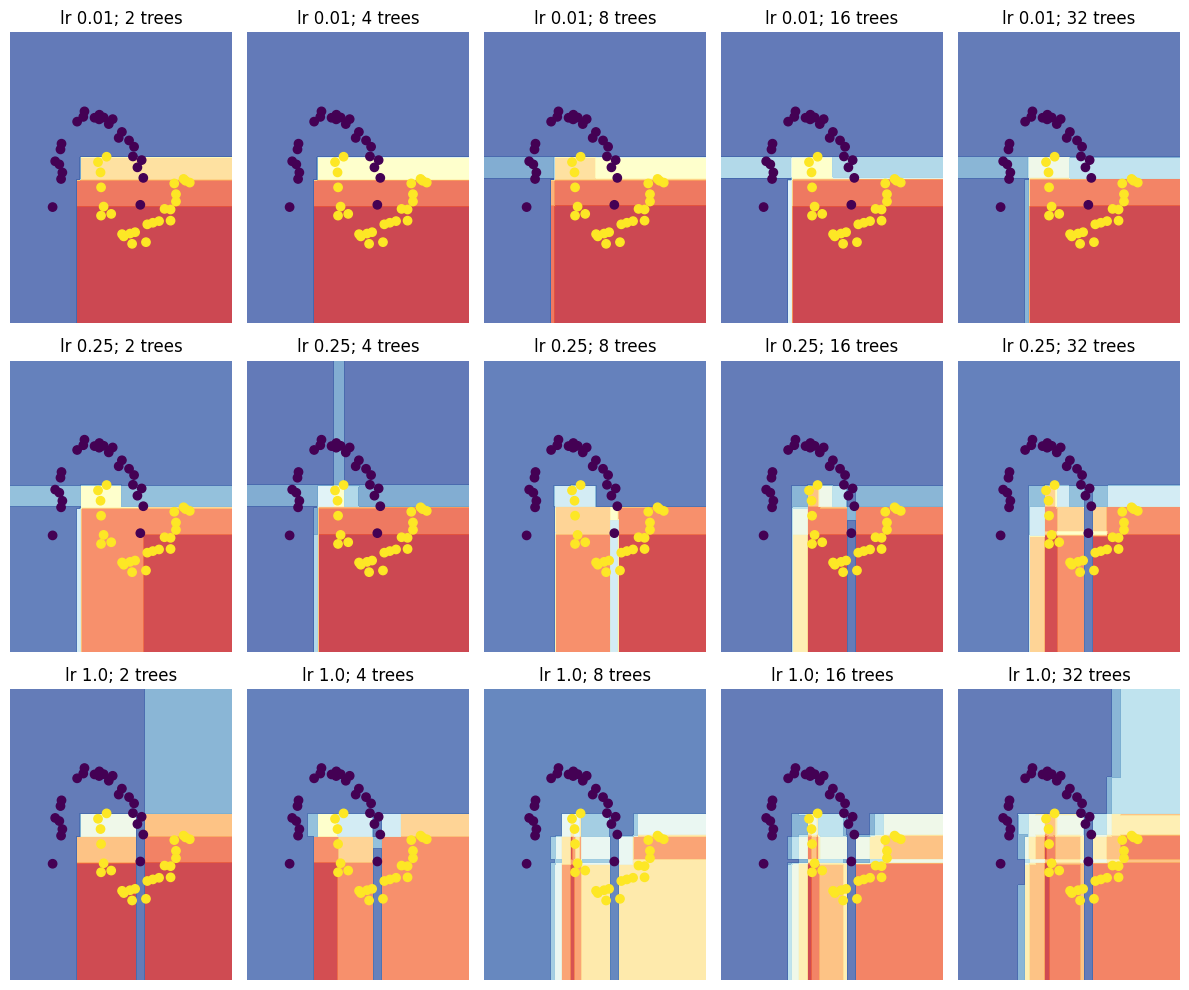

In [14]:
dict_p = {'values': [0.01, 0.25, 1.], 'name': 'learning_rate'}
draw_hyper(dict_p, 'lr')

# Subsample

Make the same plots for other hyperparameters of the algorithm. Read the documentation, to see what are the options. For example your can try different `subsample` sizes. 

In [15]:
??GradientBoostingClassifier

Init signature:
GradientBoostingClassifier(
    *,
    loss='log_loss',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    init=None,
    random_state=None,
    max_features=None,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
)
Source:        
class GradientBoostingClassifier(ClassifierMixin, BaseGradientBoosting):
    """Gradient Boosting for classification.

    This algorithm builds an additive model in a forward stage-wise fashion; it
    allows for the optimization of arbitrary differentiable loss functions. In
    each stage ``n_classes_`` regression trees are fit on the negative gradient
    of the loss function, e.g. binary or multiclass log loss. Binary
    classification is a special case where o

In [16]:
# try different subsamples
dict_p = {'values': [0.01, 0.25, 0.5, 1.], 'name': 'subsample'}

# make the plot

In [17]:
# try other hyperparameters
